In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os
import re

import lime
import lime.lime_tabular

In [2]:
saveFigures=False

In [3]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

In [7]:
elemProp = pd.read_excel('datasets/ElementalDensityIonizationTable.xlsx')
elemDensity = elemProp[['symbol', 'density [g/cm3]']]

def vegardsDensity(comp):
    '''
    input: Composition object
    '''
        
    density=0
    elemSet = set(comp.elements)
    subscriptCnt = 0
    
    for elem in elemSet:
        subscriptCnt += comp[elem]
        try: 
            densityPart = comp[elem]*elemDensity[ elemDensity['symbol'] == str(elem)]['density [g/cm3]'].item()
        except:
            print('element {} not found?'.format(elem))
            return 'error'
            
        density += densityPart
        # print('element {} added density of {}: {}'.format(elem, densityPart, density))
                
    # print(subscriptCnt)
    return density / subscriptCnt

# Build Model: Density

Import feature set, import data

In [54]:
with gzip.open('./datasets/density_features_subset.pkl.gz', 'rb') as fp:
    X_dens = pkl.load(fp)
with gzip.open('./datasets/density_data_subset.pkl.gz', 'rb') as fd:
    densityData = pkl.load(fd)
with gzip.open('./datasets/reduced_feats.pkl.gz', 'rb') as fr:
    reduced_feats = pkl.load(fr)

In [30]:
density_model = RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12)
dens_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [69]:
feature_names = reduced_feats
densityData = densityData[['comp', 'density']]

In [70]:
densityData.head()

,comp,density
0,"(Ce, Al)",3.462
1,"(Al, Fe, B)",3.539
2,"(Zr, Al, Ni)",3.384
3,"(Zr, Al, Ni)",3.517
4,"(Hf, Al, Ni)",2.835


In [71]:
# make scorer for r2 metric
r2_scorer = make_scorer(r2_score)

# Assess quality of model, identify outliers, refine model

Compare to Vegard's law, rule of mixtures

In [72]:
densityData['density_vegards'] = np.nan
densityData['density_vegards'] = [vegardsDensity(c) for c in densityData['comp']]

In [73]:
densDiffModel = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

Train Models on cleaned datasets (cleaned in book 1)

In [74]:
# how is learning in general without outliers?  Train on whole feature set
densFeatTop = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
densityData['density_predict'] = np.nan
for train_index, test_index in kf.split(densityData['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_dens[train_index,:], densityData['density'][train_index])
    
    y_densPredict = density_model.predict(X_dens[test_index,:])
    densityData['density_predict'][test_index] = y_densPredict
    
    featureImp = pd.DataFrame(density_model.feature_importances_,
                          index=feature_names,
                          columns=['importance']).sort_values('importance',ascending=False)
    #print(featureImp.head())
    
    densFeatTop = densFeatTop.append(featureImp)

    rep+=1

Split #0
Split #1
Split #2
Split #3
Split #4


In [75]:
densFeatTop['totalImp'] = densFeatTop.groupby(level=0)['importance'].transform('sum')
densFeatTop = densFeatTop.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
densFeatTop.head()

#densFeatTop.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityNoOutliers.csv'))

top features over 5 training splits


,importance,totalImp
feat_name,,
mode Number,0.086439,0.965285
mode NValence,0.118610,0.831012
mean NValence,0.162785,0.754027
mean Electronegativity,0.156671,0.425250
mean Number,0.034662,0.261274


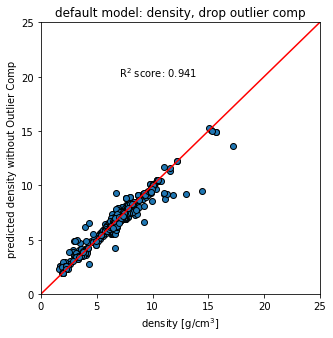

In [76]:
# plot Comparison, report r2
r2noOut = r2_score(densityData['density'], densityData['density_predict'])

plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density without Outlier Comp')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2noOut))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('default model: density, drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_noOutliers_allFeats.png'))
    print('figure saved')

# Lime?

In [77]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_dens, feature_names=feature_names, mode='regression', verbose=True)

In [85]:
i = 200
print(densityData.iloc[i])
exp = explainer.explain_instance(X_dens[i], density_model.predict)

comp               (Zr, Al, Cu)
density                   7.221
density_vegards          7.7329
density_predict         7.34999
Name: 200, dtype: object
Intercept 6.337354631414654
Prediction_local [7.16521013]
Right: 7.200759999999999


In [86]:
exp.show_in_notebook(show_table=True, show_all=True)

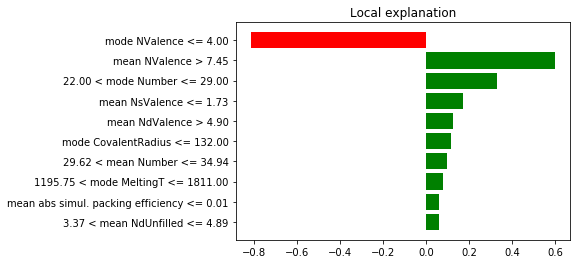

In [87]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [83]:
exp.as_list()

[('mode Number <= 22.00', -1.3938982517346827),
 ('mode NValence <= 4.00', -0.7755704793732433),
 ('mode MeltingT <= 1195.75', -0.25974505085820865),
 ('mean Column <= 4.96', -0.22729657921975807),
 ('mean Electronegativity <= 1.46', -0.20820472452317731),
 ('4.77 < mean NValence <= 6.03', -0.13368410693260152),
 ('22.79 < mean Number <= 29.62', -0.1268247791696415),
 ('mean MeltingT <= 1243.12', -0.10835983813069944),
 ('mean NdUnfilled <= 0.90', -0.1000702701069886),
 ('avg_dev MendeleevNumber <= 7.08', 0.08823610520966667)]

## Train on difference between density and vegards, see what features float up
Not including outliers

In [32]:
notTroubleDF['vegards_diff'] = notTroubleDF['density'] - notTroubleDF['density_vegards']

In [33]:
# Train on difference
diffFeatTop5 = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['diff_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['vegards_diff'][train_index])
    
    y_diffPredict = density_model.predict(X_notTrouble[test_index,:])
    notTroubleDF['diff_predict'][test_index] = y_diffPredict
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    #print(featureImp.head())
    
    diffFeatTop5 = diffFeatTop5.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0, training on 555
Split #1, training on 555
Split #2, training on 555
Split #3, training on 555
Split #4, training on 556


In [34]:
diffFeatTop5['totalImp'] = diffFeatTop5.groupby(level=0)['importance'].transform('sum')
diffFeatTop = diffFeatTop5.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
print(diffFeatTop.head())
#diffFeatTop.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityVegardsDiff.csv'))

top features over 5 training splits
                        importance  totalImp
minimum CovalentRadius    0.028763  0.163264
mean GSbandgap            0.034904  0.154511
avg_dev GSbandgap         0.043559  0.153832
avg_dev Column            0.030169  0.147618
minimum GSvolume_pa       0.022036  0.141864


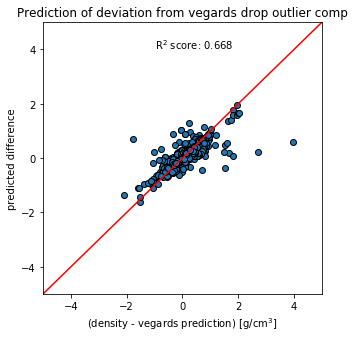

In [35]:
# plot Comparison, report r2
r2noOutDiff = r2_score(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'], edgecolors='k')
plt.plot([-5,5], [-5,5], 'r-')
plt.xlabel('(density - vegards prediction) [g/cm$^3$]')
plt.ylabel('predicted difference')


plt.text(-1,4, 'R$^2$ score: {:.3f}'.format(r2noOutDiff))
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.title('Prediction of deviation from vegards drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityDiffScatter_noOutliers.png'))
    print('figure saved')

In [36]:
# Look at mean absolute err with this new data set:

mae = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_predict'])
mae_vegards = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_vegards'])
print('MAE for random forest: {:.4f} vs vegards law {:.4f}'.format(mae, mae_vegards))
mae_diff = mean_absolute_error(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])
print(mae_diff)

MAE for random forest: 0.2974 vs vegards law 0.4477
0.1830467270241961


# Assess performance of using difference predictions instead of full model 

0.9775209241439686


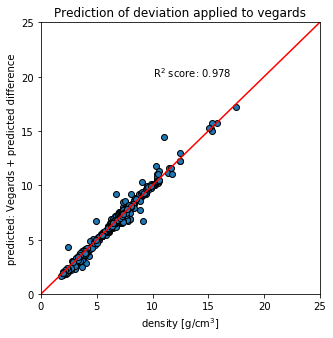

In [37]:
notTroubleDF['vPlusDiff'] = notTroubleDF['density_vegards'] + notTroubleDF['diff_predict']
r2Comp = r2_score(notTroubleDF['density'], notTroubleDF['vPlusDiff'])
print(r2Comp)

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vPlusDiff'], notTroubleDF['density'], edgecolors='k')
plt.plot([0,25], [0,25], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted: Vegards + predicted difference')


plt.text(10,20, 'R$^2$ score: {:.3f}'.format(r2Comp))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Prediction of deviation applied to vegards')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityDiffScatter_VegardsPlusDiff.png'))
    print('figure saved')

# Gather Materials Project data and try to predict compositions.

In [38]:
with gzip.open('./datasets/MAPI_density_data.pkl.gz', 'rb') as fd:
    MAPIdata = pkl.load(fd)
with gzip.open('./datasets/MAPI_density_dataAll.pkl.gz', 'rb') as fd:
    MAPIall = pkl.load(fd)
with gzip.open('./datasets/MAPI_density_featuresAll.pkl.gz', 'rb') as fd:
    X_mapiAll = pkl.load(fd)

In [39]:
MAPIdata['density_vegards'] = [vegardsDensity(c) for c in MAPIdata['comp']]
MAPIdata['vegards_diff'] = MAPIdata['density'] - MAPIdata['density_vegards']

In [40]:
dens_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [41]:
%%time
try:
    with gzip.open('./datasets/MAPI_density_SubsetFeats.pkl.gz', 'rb') as fd:
        X_mapi = pkl.load(fd)     
    with gzip.open('./datasets/MAPI_density_SubsetData.pkl.gz', 'rb') as fb:
        subsetMAPI = pkl.load(fb)     
    
except Exception as e:
    print(e)
    print('Feature file not found, featurizing')
    
    subsetMAPI = MAPIdata.sample(n=701)
    subsetMAPI.reset_index(inplace=True, drop=True)

    X_mapi = dens_featurizer.featurize_many(subsetMAPI['comp'], ignore_errors=True)
    X_mapi = np.array(X_mapi)
    X_mapi.astype(float)
    print('Computed {} features'.format(X_mapi.shape[1]))

    print('Exporting features and selected subset')
    with gzip.open('./datasets/MAPI_density_SubsetData.pkl.gz', 'wb') as fb:
        pkl.dump(subsetMAPI, fb)
    with gzip.open('./datasets/MAPI_density_SubsetFeats.pkl.gz', 'wb') as fd:
        pkl.dump(X_mapi, fd)
    

Wall time: 60 ms


In [42]:
print(np.where(np.isnan(X_mapi)))
featCleanImpute(X_mapi)
print(np.where(np.isnan(X_mapi)))
print(np.where(np.isnan(X_mapiAll)))
featCleanImpute(X_mapiAll)
print(np.where(np.isnan(X_mapiAll)))

(array([  0,   2,   3,   3,   4,   5,   6,   7,   9,  10,  11,  12,  12,
        13,  14,  15,  16,  17,  19,  20,  21,  23,  24,  26,  28,  29,
        30,  31,  35,  37,  38,  38,  39,  40,  41,  44,  47,  48,  50,
        51,  51,  52,  54,  55,  56,  58,  60,  60,  61,  62,  63,  64,
        64,  66,  67,  68,  69,  70,  72,  73,  74,  75,  77,  78,  79,
        80,  81,  82,  85,  85,  87,  88,  91,  94,  97,  98,  99, 101,
       102, 103, 104, 105, 106, 108, 110, 110, 111, 113, 114, 115, 116,
       117, 118, 120, 121, 122, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 130, 131, 132, 134, 135, 136, 137, 142, 143, 144, 147, 148,
       149, 150, 151, 153, 154, 155, 155, 156, 159, 160, 162, 163, 165,
       166, 167, 168, 170, 171, 171, 172, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193,
       195, 196, 197, 198, 198, 199, 200, 201, 201, 202, 203, 204, 204,
       205, 206, 207, 208, 209, 210, 210, 211, 212, 213, 214, 2

In [43]:
MAPIall.reset_index(drop=True, inplace=True)
MAPIall['density_vegards'] = [vegardsDensity(c) for c in MAPIall['comp']]

In [44]:
subsetMAPI['density_vegards'] = [vegardsDensity(c) for c in subsetMAPI['comp']]
subsetMAPI['vegards_diff'] = subsetMAPI['density'] - subsetMAPI['density_vegards']

In [45]:
MAPIdata.head()

,density,material_id,pretty_formula,comp,density_vegards,vegards_diff
0,5.752872,mp-20338,CeAl3Ni2,"(Ce, Al, Ni)",5.445000,0.307872
1,4.807903,mp-30750,CeAl4Ni,"(Ce, Al, Ni)",4.411667,0.396236
2,4.597243,mp-582245,Ce4Al23Ni6,"(Ce, Al, Ni)",4.320606,0.276637
3,6.768836,mp-11351,CeAlNi,"(Ce, Al, Ni)",6.123333,0.645503
4,4.901765,mp-4817,CeAl5Ni2,"(Ce, Al, Ni)",4.758750,0.143015


In [46]:
%%time 
# Train on all database info
density_model.fit(X_notTrouble, y=notTroubleDF['density'])

Wall time: 380 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

# Predict Crystalline data using model trained on Amorphous glasses.  
We do not expect this to do well.  Using all crystalline data from MAPI, not just subset from same ternaries

In [47]:
%%time
# Predct MAPI data
yMAPI = density_model.predict(X_mapiAll)

Wall time: 580 ms


In [48]:
MAPIall['density_predict'] = yMAPI
r2_score(MAPIall['density'], MAPIall['density_predict'])

0.3782073831975018

0.3782073831975018
figure saved


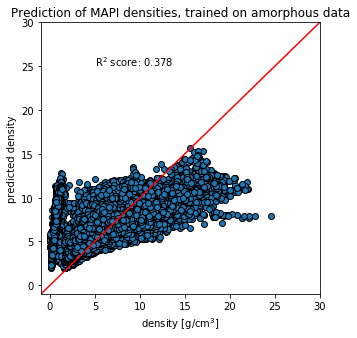

In [60]:
r2mapi = r2_score(MAPIall['density'], MAPIall['density_predict'])
print(r2mapi)

plt.figure(figsize=(5,5))
plt.scatter(MAPIall['density'], MAPIall['density_predict'], edgecolors='k')
plt.plot([-5,30], [-5,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density')


plt.text(5,25, 'R$^2$ score: {:.3f}'.format(r2mapi))
plt.xlim([-1,30])
plt.ylim([-1,30])
plt.title('Prediction of MAPI densities, trained on amorphous data')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_MAPIonAmModel.png'))
    print('figure saved')

## Fit Crystalline data on its own.

In [62]:
densCr_model = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [63]:
# Train on difference
crFeatTop5 = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
MAPIall['densCr_predict'] = np.nan
for train_index, test_index in kf.split(MAPIall['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    densCr_model.fit(X_mapiAll[train_index,:], MAPIall['density'][train_index])
    
    y_cr = densCr_model.predict(X_mapiAll[test_index,:])
    MAPIall['densCr_predict'][test_index] = y_cr
    
    featureImp = pd.DataFrame(densCr_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    #print(featureImp.head())
    
    crFeatTop5 = crFeatTop5.append(featureImp)

    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0, training on 45080
Split #1, training on 45081
Split #2, training on 45081
Split #3, training on 45081
Split #4, training on 45081


In [64]:
crFeatTop5['totalImp'] = crFeatTop5.groupby(level=0)['importance'].transform('sum')
crFeatTop5 = crFeatTop5.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
print(crFeatTop5.head())
#crFeatTop5.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityCrMAPI.csv'))

top features over 5 training splits
                         importance  totalImp
mean AtomicWeight          0.051594  0.269570
mean NfValence             0.033094  0.232648
maximum Number             0.039152  0.221285
mean Number                0.040070  0.204500
avg f valence electrons    0.042889  0.187651


0.8205733380897304


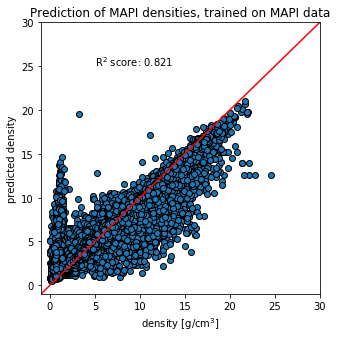

In [65]:
r2cr = r2_score(MAPIall['density'], MAPIall['densCr_predict'])
print(r2cr)

plt.figure(figsize=(5,5))
plt.scatter(MAPIall['density'], MAPIall['densCr_predict'], edgecolors='k')
plt.plot([-5,30], [-5,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density')


plt.text(5,25, 'R$^2$ score: {:.3f}'.format(r2cr))
plt.xlim([-1,30])
plt.ylim([-1,30])
plt.title('Prediction of MAPI densities, trained on MAPI data')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_MAPI.png'))
    print('figure saved')

0.48499800492513157
figure saved


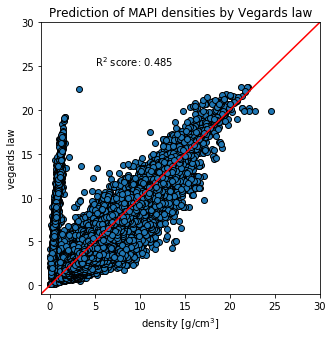

In [66]:
r2cr = r2_score(MAPIall['density'], MAPIall['density_vegards'])
print(r2cr)

plt.figure(figsize=(5,5))
plt.scatter(MAPIall['density'], MAPIall['density_vegards'], edgecolors='k')
plt.plot([-5,30], [-5,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('vegards law')


plt.text(5,25, 'R$^2$ score: {:.3f}'.format(r2cr))
plt.xlim([-1,30])
plt.ylim([-1,30])
plt.title('Prediction of MAPI densities by Vegards law')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityVegardsScatter_MAPI.png'))
    print('figure saved')

In [61]:
MAPIall[MAPIall['pretty_formula']=='EuAg']

,density,material_id,pretty_formula,comp,density_vegards,density_predict,densCr_predict
916,0.224200,mp-623782,EuAg,"(Eu, Ag)",7.87,7.104971,8.461594
921,7.240127,mp-665747,EuAg,"(Eu, Ag)",7.87,7.104971,8.461594


# Outlier searching in MAPI dataset

In [74]:
nonOut = MAPIall[ MAPIall['density'] > 2]
r2nonOut = r2_score(nonOut['density'], nonOut['density_vegards'])
print(r2nonOut)

0.7321079762059536


0.7321079762059536


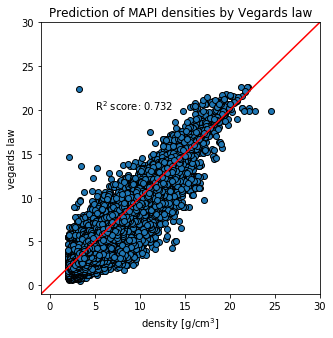

In [75]:
r2cr = r2_score(nonOut['density'], nonOut['density_vegards'])
print(r2cr)

plt.figure(figsize=(5,5))
plt.scatter(nonOut['density'], nonOut['density_vegards'], edgecolors='k')
plt.plot([-5,30], [-5,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('vegards law')


plt.text(5,20, 'R$^2$ score: {:.3f}'.format(r2cr))
plt.xlim([-1,30])
plt.ylim([-1,30])
plt.title('Prediction of MAPI densities by Vegards law')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityVegardsScatter_MAPI.png'))
    print('figure saved')

In [76]:
MPoutliers = MAPIall[ (MAPIall['density'] < 2) & (MAPIall['density_vegards']>5)]
MPoutliers.reset_index(drop=True, inplace=True)

-905.8463430939564


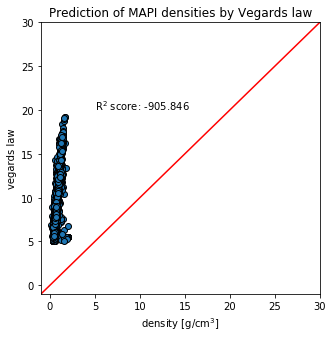

In [79]:
r2cr = r2_score(MPoutliers['density'], MPoutliers['density_vegards'])
print(r2cr)

plt.figure(figsize=(5,5))
plt.scatter(MPoutliers['density'], MPoutliers['density_vegards'], edgecolors='k')
plt.plot([-5,30], [-5,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('vegards law')


plt.text(5,20, 'R$^2$ score: {:.3f}'.format(r2cr))
plt.xlim([-1,30])
plt.ylim([-1,30])
plt.title('Prediction of MAPI densities by Vegards law')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityVegardsScatter_MAPI.png'))
    print('figure saved')

In [77]:
#len(MPoutliers[MPoutliers['pretty_formula']=='CeSe2'])
MPoutliers.to_csv(os.path.join(os.getcwd(),'results','MAPIoutliers.csv'))

In [84]:
np.mean(MPoutliers['comp'].apply(len))

2.9688457609805923

# Model trained on difference between crysytalline and vegards

In [67]:
densDiffModel_mapi = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [68]:
MAPIall['vegards_diff'] = MAPIall['density'] - MAPIall['density_vegards']

In [69]:
# Train on difference
diffMAPI = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
MAPIall['diff_predict'] = np.nan
for train_index, test_index in kf.split(MAPIall['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    densDiffModel_mapi.fit(X_mapiAll[train_index,:], MAPIall['vegards_diff'][train_index])
    
    y_diffPredict = densDiffModel_mapi.predict(X_mapiAll[test_index,:])
    MAPIall['diff_predict'][test_index] = y_diffPredict
    
    
    featureImp = pd.DataFrame(densDiffModel_mapi.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    #print(featureImp.head())
    
    diffMAPI = diffMAPI.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0, training on 45080
Split #1, training on 45081
Split #2, training on 45081
Split #3, training on 45081
Split #4, training on 45081


In [70]:
diffMAPI['totalImp'] = diffMAPI.groupby(level=0)['importance'].transform('sum')
diffMAPI = diffMAPI.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
print(diffMAPI.head())
#diffFeatTop.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityVegardsDiff.csv'))

top features over 5 training splits
                        importance  totalImp
minimum CovalentRadius    0.024296  0.142916
mode CovalentRadius       0.027344  0.130930
mode Number               0.026662  0.122426
mode AtomicWeight         0.019546  0.119627
Yang delta                0.024930  0.095764


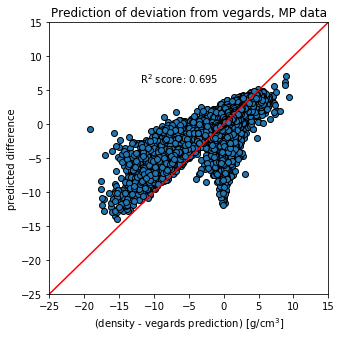

In [71]:
# plot Comparison, report r2
r2mapiDiff = r2_score(MAPIall['vegards_diff'], MAPIall['diff_predict'])

plt.figure(figsize=(5,5))
plt.scatter(MAPIall['vegards_diff'], MAPIall['diff_predict'], edgecolors='k')
plt.plot([-25,15], [-25,15], 'r-')
plt.xlabel('(density - vegards prediction) [g/cm$^3$]')
plt.ylabel('predicted difference')


plt.text(-12,6, 'R$^2$ score: {:.3f}'.format(r2mapiDiff))
plt.xlim([-25,15])
plt.ylim([-25,15])
plt.title('Prediction of deviation from vegards, MP data')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityDiffScatter_MP.png'))
    print('figure saved')

Apply difference predictions to vegards law

0.8481614607105096
figure saved


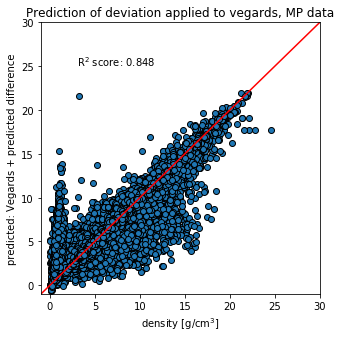

In [73]:
MAPIall['vPlusDiff'] =  MAPIall['density_vegards'] + MAPIall['diff_predict']
r2Comp = r2_score(MAPIall['density'], MAPIall['vPlusDiff'])
print(r2Comp)

plt.figure(figsize=(5,5))
plt.scatter(MAPIall['density'], MAPIall['vPlusDiff'], edgecolors='k')
plt.plot([-1,30], [-1,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted: Vegards + predicted difference')


plt.text(3,25, 'R$^2$ score: {:.3f}'.format(r2Comp))
plt.xlim([-1,30])
plt.ylim([-1, 30])
plt.title('Prediction of deviation applied to vegards, MP data')

if True:
    plt.savefig(os.path.join(os.getcwd(),'results','densityVPlusDiff_MP.png'))
    print('figure saved')

In [79]:
MAPIall.head()

,density,material_id,pretty_formula,comp,density_vegards,density_predict,densCr_predict,vegards_diff,diff_predict,vPlusDiff
0,1.935217,mp-1,Cs,(Cs),1.87,4.986356,2.656424,0.065217,-0.518385,1.351615
1,6.064411,mp-10,As,(As),5.72,8.145716,5.810103,0.344411,-0.552273,5.167727
2,13.343941,mp-100,Hf,(Hf),13.31,9.379831,13.203554,0.033941,-1.265796,12.044204
3,3.037094,mp-1001113,Si,(Si),2.33,4.413994,2.815457,0.707094,-0.254900,2.075100
4,8.305509,mp-10018,Ac,(Ac),10.07,7.198488,9.287044,-1.764491,-0.475718,9.594282


In [82]:
def getAlloySet(data):
    '''Returns set of alloy element sets, iterating over 
        all items in ['composition'] column
        
    Args: 
        data (DataFrame): alloy data, must have 'composition' column
    Returns:
        (set): each item of the returned set is a set with strings 
                denoting element symbols
    '''
    alloys=set()
    
    for comp in data.tolist():
        curr = frozenset(comp.as_dict().keys())
        alloys.add(curr)
    
    return alloys

In [89]:
mapiCompList = getAlloySet(MAPIall['comp'])
mgCompList = getAlloySet(densityData['comp'])

In [90]:
print(frozenset({'Ag', 'Hg', 'Au'}) in mapiCompList)
print(frozenset({'Ag', 'Hg', 'Au'}) in mgCompList)

True
False


In [94]:
len(MAPIdata)

5026

In [93]:
len(densityData)

701